/tmp/ipython-input-4147088862.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  3 of 3 completed

Ticker,AAPL,MSFT,TSLA
Date,,,
2025-12-03,284.149994,477.730011,446.739990
2025-12-04,280.700012,480.839996,454.529999
2025-12-05,278.779999,483.160004,455.000000
2025-12-08,277.890015,491.019989,439.579987
2025-12-09,277.179993,492.019989,445.170013



Estimating drift vector and covariance matrix...

Estimated annual drift (mu) per asset:
  AAPL: 0.1698
  MSFT: 0.1764
  TSLA: 0.1576

Estimated annualized covariance matrix (σ_ij):


,AAPL,MSFT,TSLA
AAPL,0.078206,0.045454,0.083390
MSFT,0.045454,0.066028,0.065340
TSLA,0.083390,0.065340,0.367604



Plotting historical price and return behaviour...


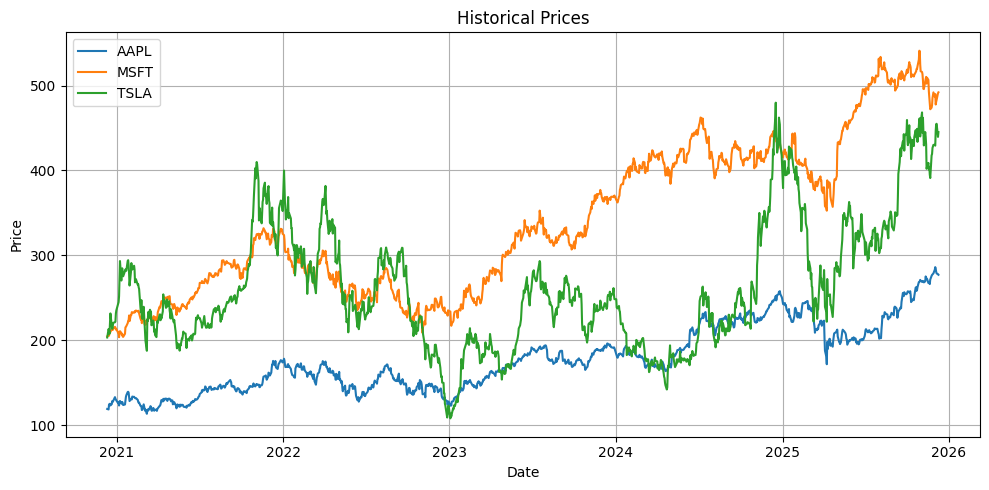

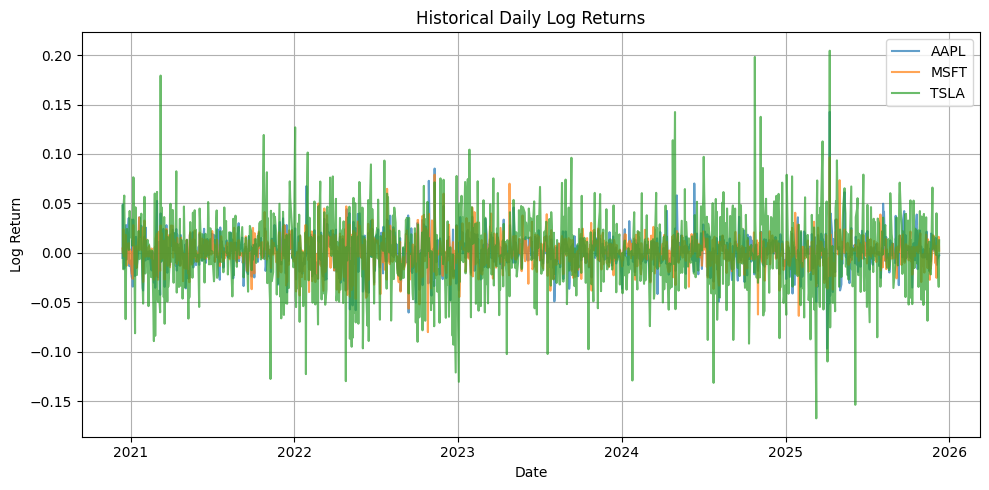

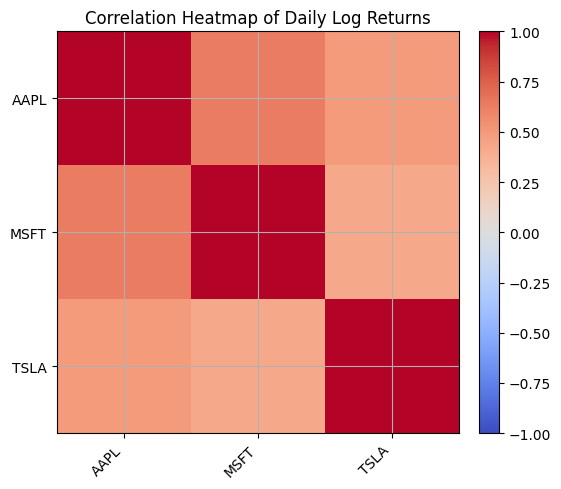


Current prices (S0):
  AAPL: 277.18
  MSFT: 492.02
  TSLA: 445.17

Simulating correlated GBM paths for all assets...

Computing portfolio paths from asset paths and weights...
Normalized weights used:
  AAPL: 50.00%
  MSFT: 30.00%
  TSLA: 20.00%

Plotting sample asset price paths...


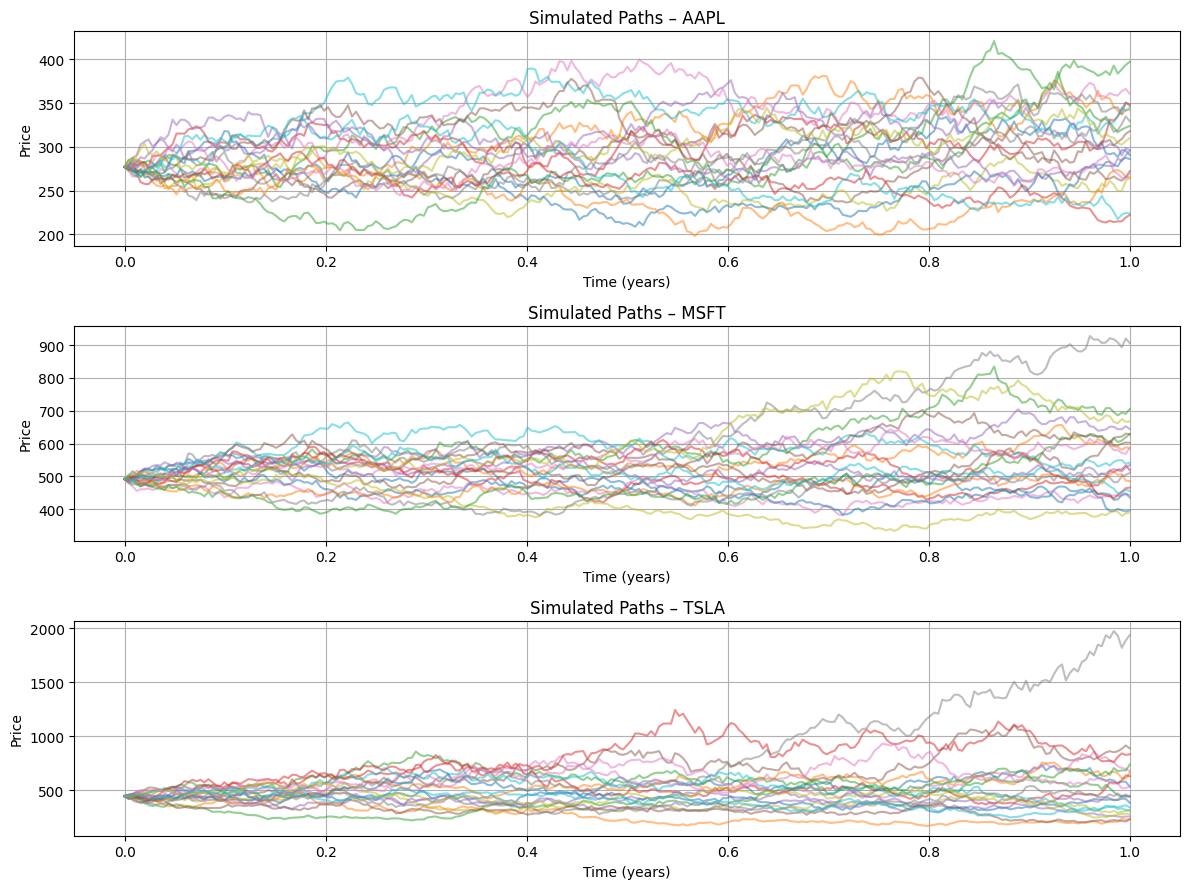

Plotting joint final asset return scatter (first two assets)...


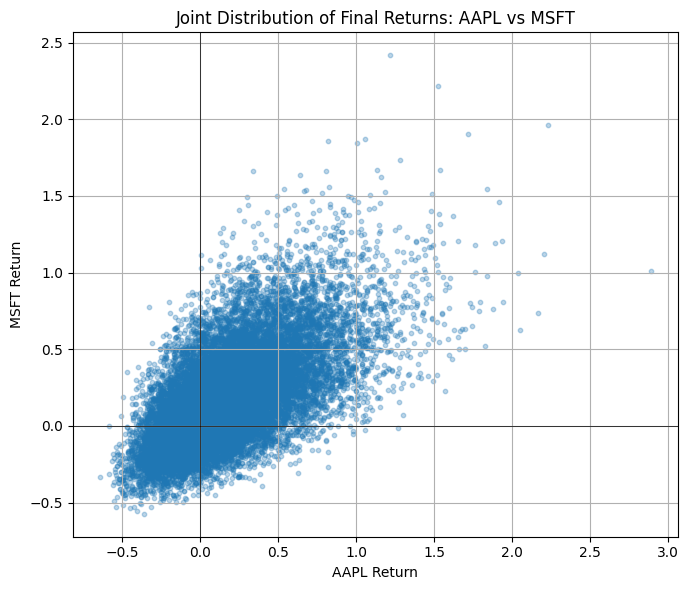

Plotting sample portfolio value paths...


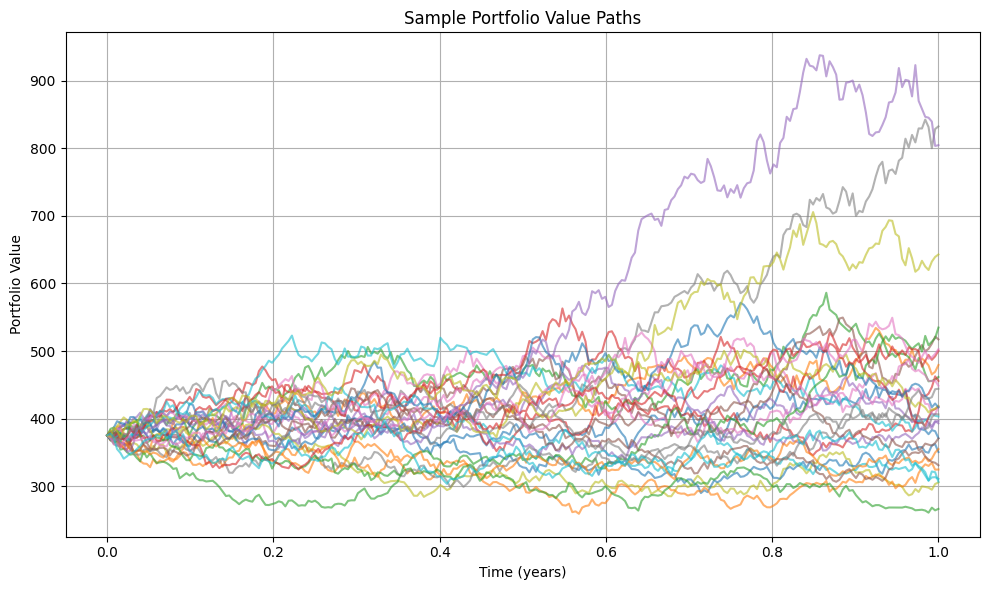

Plotting portfolio fan chart (percentile bands over time)...


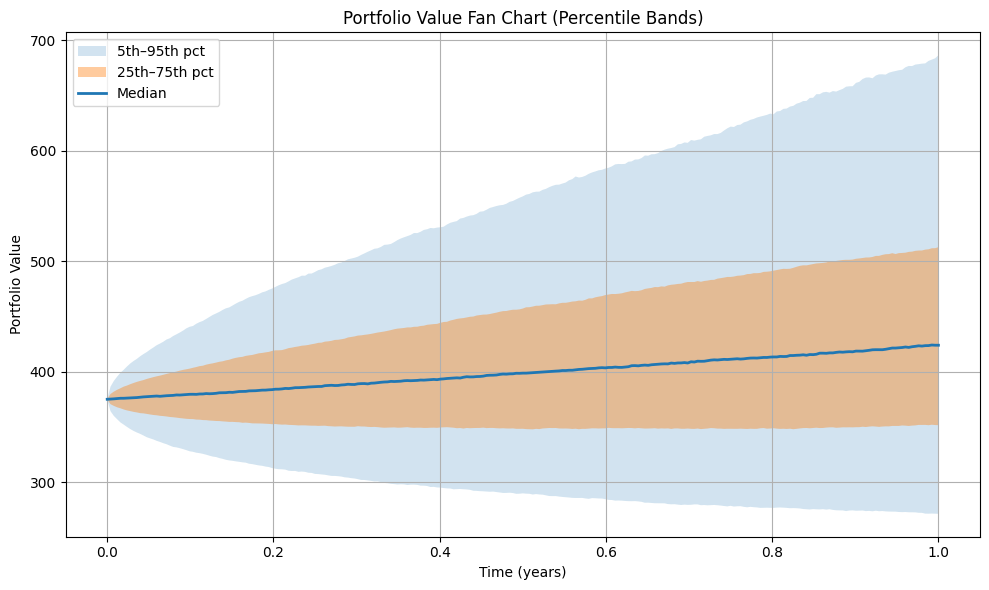

Plotting final distribution of portfolio values and returns + VaR...


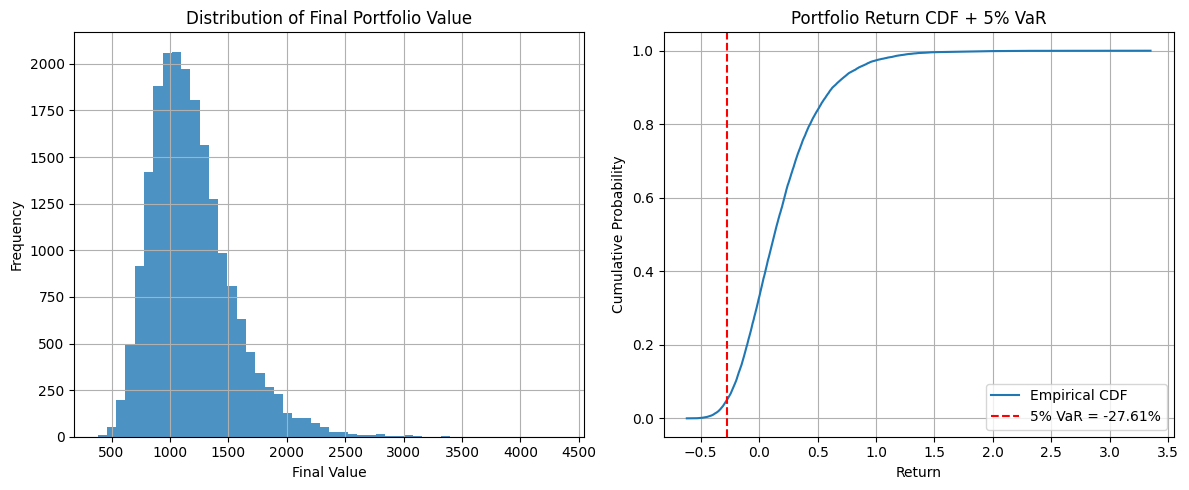

=== Final Portfolio Statistics ===
Initial investment: 1000.00
Mean final value:   1184.33
Median final value: 1130.26
5th percentile:     723.92
95th percentile:    1829.23

Mean return:        18.43%
Std of return:      34.90%
5th pct return:     -27.61%
95th pct return:    82.92%
5% VaR (loss):      -27.61%


In [5]:
# ============================================================
# Monte Carlo Simulation for Multi-Asset Portfolio Returns
# ============================================================

!pip install yfinance --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True


# ------------------------------------------------------------
# 1. Download Historical Data for Multiple Tickers
# ------------------------------------------------------------
def get_price_data(tickers, years=5):
    """
    Download price data for multiple tickers using yfinance.

    New yfinance versions use auto_adjust=True by default,
    so 'Adj Close' may not exist. We safely use 'Close'.

    tickers : list[str] e.g. ["AAPL", "MSFT", "TSLA"]
    years   : number of past years to download

    Returns: DataFrame of prices (dates x assets)
    """
    end = dt.date.today()
    start = end - dt.timedelta(days=years * 365)

    data = yf.download(tickers, start=start, end=end)

    # Prefer 'Close' (already adjusted if auto_adjust=True)
    if isinstance(data, pd.DataFrame) and "Close" in data:
        prices = data["Close"]
    else:
        prices = data.copy()
        if isinstance(prices, pd.Series):
            prices = prices.to_frame(name=tickers[0])

    prices = prices.dropna(how="all")
    return prices


# ------------------------------------------------------------
# 2. Estimate Drift Vector and Covariance Matrix
# ------------------------------------------------------------
def estimate_gbm_params_multi(price_df):
    """
    Estimate annualized drift vector and covariance matrix for multiple assets.

    price_df : DataFrame of prices (dates x tickers)

    Returns:
        mu_annual : vector (d,) annualized mean returns
        cov_annual: matrix (d,d) annualized covariance of returns
        log_ret   : DataFrame of daily log returns
    """
    # Daily log returns
    log_ret = np.log(price_df / price_df.shift(1)).dropna()

    # Daily mean returns (per asset)
    mu_daily = log_ret.mean(axis=0).values   # shape (d,)
    # Daily covariance matrix
    cov_daily = log_ret.cov().values         # shape (d,d)

    # Annualize (assuming 252 trading days)
    mu_annual = mu_daily * 252
    cov_annual = cov_daily * 252

    return mu_annual, cov_annual, log_ret


# ------------------------------------------------------------
# 3. Simulate Correlated GBM Paths (Multi-Asset)
# ------------------------------------------------------------
def simulate_gbm_paths_multi(S0_vec, mu_vec, cov_mat, T=1.0, steps=252, n_paths=10000, seed=0):
    """
    Simulate correlated GBM price paths for multiple assets.

    S0_vec : array (d,) initial prices
    mu_vec : array (d,) annual drift for each asset
    cov_mat: array (d,d) annual covariance matrix of returns
    T      : time horizon in years
    steps  : number of time steps (e.g. 252 for daily)
    n_paths: number of Monte Carlo paths
    seed   : random seed

    Returns:
        paths : array (steps+1, n_paths, d)
    """
    if seed is not None:
        np.random.seed(seed)

    S0_vec = np.asarray(S0_vec)
    mu_vec = np.asarray(mu_vec)
    cov_mat = np.asarray(cov_mat)
    d = len(S0_vec)

    # Cholesky decomposition for correlating shocks
    L = np.linalg.cholesky(cov_mat)  # L * L.T = cov_mat

    dt_step = T / steps

    # paths[t, path, asset]
    paths = np.zeros((steps + 1, n_paths, d))
    paths[0, :, :] = S0_vec  # same starting prices for all paths

    # Drift term for each asset
    drift = (mu_vec - 0.5 * np.diag(cov_mat)) * dt_step  # shape (d,)

    for t in range(1, steps + 1):
        # Generate uncorrelated standard normal shocks: (n_paths, d)
        Z = np.random.randn(n_paths, d)
        # Correlated shocks: epsilon ~ N(0, cov_mat * dt_step)
        epsilon = Z @ L.T * np.sqrt(dt_step)  # (n_paths, d)

        # GBM update
        paths[t] = paths[t - 1] * np.exp(drift + epsilon)

    return paths


# ------------------------------------------------------------
# 4. Portfolio Value from Asset Paths
# ------------------------------------------------------------
def compute_portfolio_paths(paths, weights):
    """
    Compute portfolio value paths from asset price paths and weights.

    paths   : array (steps+1, n_paths, d)
    weights : array (d,) portfolio weights (will be normalized)

    Returns:
        portfolio_paths : array (steps+1, n_paths)
        normalized_weights : array (d,)
    """
    weights = np.asarray(weights, dtype=float)
    if weights.sum() != 0:
        weights = weights / weights.sum()

    # (steps+1, n_paths, d) @ (d,) -> (steps+1, n_paths)
    portfolio_paths = np.tensordot(paths, weights, axes=([2], [0]))
    return portfolio_paths, weights


# ------------------------------------------------------------
# 5. BASIC VISUALIZATIONS
# ------------------------------------------------------------
def plot_historical_prices(price_df):
    plt.figure(figsize=(10, 5))
    for col in price_df.columns:
        plt.plot(price_df.index, price_df[col], label=col)
    plt.title("Historical Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_historical_log_returns(log_ret):
    plt.figure(figsize=(10, 5))
    for col in log_ret.columns:
        plt.plot(log_ret.index, log_ret[col], label=col, alpha=0.7)
    plt.title("Historical Daily Log Returns")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 6. ADVANCED VISUALIZATIONS
# ------------------------------------------------------------

def plot_correlation_heatmap(log_ret):
    """
    Plot correlation matrix of daily log returns.
    """
    corr = log_ret.corr()
    tickers = corr.columns

    plt.figure(figsize=(6, 5))
    im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation Heatmap of Daily Log Returns")
    plt.xticks(range(len(tickers)), tickers, rotation=45, ha="right")
    plt.yticks(range(len(tickers)), tickers)
    plt.tight_layout()
    plt.show()


def plot_asset_sample_paths(paths, tickers, n_samples=20):
    """
    Plot sample simulated paths for each asset.

    paths   : array (steps+1, n_paths, d)
    tickers : list of ticker names (length d)
    """
    t = np.linspace(0, 1, paths.shape[0])  # assuming T=1 scaled for x-axis
    d = paths.shape[2]

    plt.figure(figsize=(12, 3 * d))
    for i in range(d):
        plt.subplot(d, 1, i + 1)
        for j in range(min(n_samples, paths.shape[1])):
            plt.plot(t, paths[:, j, i], alpha=0.5)
        plt.title(f"Simulated Paths – {tickers[i]}")
        plt.xlabel("Time (years)")
        plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


def plot_final_asset_return_scatter(paths, tickers):
    """
    Scatter of final simulated asset returns (pairwise, only for first 2 assets if >2).
    """
    final_prices = paths[-1]    # shape (n_paths, d)
    S0_vec = paths[0, 0, :]     # shape (d,)
    final_returns = final_prices / S0_vec - 1.0  # (n_paths, d)

    d = final_returns.shape[1]
    if d < 2:
        print("Need at least 2 assets for scatter plot.")
        return

    x_idx, y_idx = 0, 1  # use first two assets
    x = final_returns[:, x_idx]
    y = final_returns[:, y_idx]

    plt.figure(figsize=(7, 6))
    plt.scatter(x, y, alpha=0.3, s=10)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.xlabel(f"{tickers[x_idx]} Return")
    plt.ylabel(f"{tickers[y_idx]} Return")
    plt.title(f"Joint Distribution of Final Returns: {tickers[x_idx]} vs {tickers[y_idx]}")
    plt.tight_layout()
    plt.show()


def plot_portfolio_paths(portfolio_paths, n_samples=30):
    """
    Plot sample portfolio value paths.

    portfolio_paths : array (steps+1, n_paths)
    """
    t = np.linspace(0, 1, portfolio_paths.shape[0])

    plt.figure(figsize=(10, 6))
    for i in range(min(n_samples, portfolio_paths.shape[1])):
        plt.plot(t, portfolio_paths[:, i], alpha=0.6)
    plt.title("Sample Portfolio Value Paths")
    plt.xlabel("Time (years)")
    plt.ylabel("Portfolio Value")
    plt.tight_layout()
    plt.show()


def plot_portfolio_fan_chart(portfolio_paths):
    """
    Plot percentile bands (fan chart) for portfolio values over time.
    """
    t = np.linspace(0, 1, portfolio_paths.shape[0])
    percentiles = [5, 25, 50, 75, 95]
    perc_vals = np.percentile(portfolio_paths, percentiles, axis=1)  # shape (len(p), steps+1)

    plt.figure(figsize=(10, 6))
    # Fan bands
    plt.fill_between(t, perc_vals[0], perc_vals[-1], alpha=0.2, label="5th–95th pct")
    plt.fill_between(t, perc_vals[1], perc_vals[-2], alpha=0.4, label="25th–75th pct")
    # Median
    plt.plot(t, perc_vals[2], label="Median", linewidth=2)

    plt.title("Portfolio Value Fan Chart (Percentile Bands)")
    plt.xlabel("Time (years)")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_portfolio_final_distribution(portfolio_paths, initial_investment=1.0):
    """
    Plot distribution of final portfolio values and returns + CDF with VaR.

    portfolio_paths : array (steps+1, n_paths)
    """
    final_values = portfolio_paths[-1]
    initial_value = portfolio_paths[0, 0]  # same across paths

    # Scale to chosen initial investment
    scaled_final_values = final_values / initial_value * initial_investment
    returns = scaled_final_values / initial_investment - 1.0

    plt.figure(figsize=(12, 5))

    # Final value distribution (hist)
    plt.subplot(1, 2, 1)
    plt.hist(scaled_final_values, bins=50, alpha=0.8)
    plt.title("Distribution of Final Portfolio Value")
    plt.xlabel("Final Value")
    plt.ylabel("Frequency")

    # Return distribution with CDF & VaR
    plt.subplot(1, 2, 2)
    sorted_returns = np.sort(returns)
    cdf = np.linspace(0, 1, len(sorted_returns))

    plt.plot(sorted_returns, cdf, label="Empirical CDF")
    # Value-at-Risk at 5%
    var_level = 0.05
    var_5 = np.percentile(returns, var_level * 100)
    plt.axvline(var_5, color="red", linestyle="--", label=f"5% VaR = {var_5:.2%}")

    plt.title("Portfolio Return CDF + 5% VaR")
    plt.xlabel("Return")
    plt.ylabel("Cumulative Probability")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("=== Final Portfolio Statistics ===")
    print(f"Initial investment: {initial_investment:.2f}")
    print(f"Mean final value:   {scaled_final_values.mean():.2f}")
    print(f"Median final value: {np.median(scaled_final_values):.2f}")
    print(f"5th percentile:     {np.percentile(scaled_final_values, 5):.2f}")
    print(f"95th percentile:    {np.percentile(scaled_final_values, 95):.2f}")
    print()
    print(f"Mean return:        {returns.mean():.2%}")
    print(f"Std of return:      {returns.std():.2%}")
    print(f"5th pct return:     {np.percentile(returns, 5):.2%}")
    print(f"95th pct return:    {np.percentile(returns, 95):.2%}")
    print(f"5% VaR (loss):      {var_5:.2%}")


# ------------------------------------------------------------
# 7. Glue Everything Together
# ------------------------------------------------------------
if __name__ == "__main__":
    # ------------------------------
    # USER SETTINGS
    # ------------------------------
    TICKERS = ["AAPL", "MSFT", "TSLA"]   # change or add tickers here
    YEARS_HISTORY = 5                    # how many years of data to use
    T = 1.0                              # simulate 1 year into the future
    STEPS = 252                          # daily steps
    N_PATHS = 20000                      # number of Monte Carlo simulations

    # Portfolio weights (same length as TICKERS)
    WEIGHTS = np.array([0.5, 0.3, 0.2])

    print(f"Downloading {YEARS_HISTORY} years of data for: {TICKERS}")
    prices_df = get_price_data(TICKERS, years=YEARS_HISTORY)
    display(prices_df.tail())

    print("\nEstimating drift vector and covariance matrix...")
    mu_vec, cov_mat, log_ret = estimate_gbm_params_multi(prices_df)
    print("\nEstimated annual drift (mu) per asset:")
    for tkr, m in zip(TICKERS, mu_vec):
        print(f"  {tkr}: {m:.4f}")
    print("\nEstimated annualized covariance matrix (σ_ij):")
    display(pd.DataFrame(cov_mat, index=TICKERS, columns=TICKERS))

    # === Historical visualizations ===
    print("\nPlotting historical price and return behaviour...")
    plot_historical_prices(prices_df)
    plot_historical_log_returns(log_ret)
    plot_correlation_heatmap(log_ret)

    S0_vec = prices_df.iloc[-1].values
    print("\nCurrent prices (S0):")
    for tkr, s0 in zip(TICKERS, S0_vec):
        print(f"  {tkr}: {s0:.2f}")

    print("\nSimulating correlated GBM paths for all assets...")
    paths = simulate_gbm_paths_multi(
        S0_vec, mu_vec, cov_mat, T=T, steps=STEPS, n_paths=N_PATHS, seed=42
    )

    print("\nComputing portfolio paths from asset paths and weights...")
    portfolio_paths, normalized_weights = compute_portfolio_paths(paths, WEIGHTS)
    print("Normalized weights used:")
    for tkr, w in zip(TICKERS, normalized_weights):
        print(f"  {tkr}: {w:.2%}")

    # === Advanced simulation visualizations ===
    print("\nPlotting sample asset price paths...")
    plot_asset_sample_paths(paths, TICKERS, n_samples=20)

    print("Plotting joint final asset return scatter (first two assets)...")
    plot_final_asset_return_scatter(paths, TICKERS)

    print("Plotting sample portfolio value paths...")
    plot_portfolio_paths(portfolio_paths, n_samples=30)

    print("Plotting portfolio fan chart (percentile bands over time)...")
    plot_portfolio_fan_chart(portfolio_paths)

    print("Plotting final distribution of portfolio values and returns + VaR...")
    plot_portfolio_final_distribution(portfolio_paths, initial_investment=1000.0)
